ML PROJECT



# Installing necessory packages

In [1]:
!pip install icecream
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-pla

# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torch.autograd import Variable
import time
import tqdm
import copy
import numpy as np
import requests, io
from icecream import ic
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from torch.autograd import Variable

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, mean_absolute_error, mean_squared_error, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline


# Training Parameters

In [3]:
BATCH_SIZE = 8
LEARNING_RATE = 0.01
NUM_OF_EPOCHS = 20
DECAY = 0.00000 

# Dataset downloading and Data Augmentation

In [4]:
train_dataset = datasets.STL10(root='./data', split = 'train', transform=transforms.ToTensor(), download=True)
test_dataset = datasets.STL10(root='./data', split = 'test', transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

# Transfer learning from ResNet 50 model

In [6]:
model = models.resnet50(pretrained=True) 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.cuda()
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Creating cross entropy loss function

In [7]:
loss = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)

# Model Training without Adversarial Images

In [8]:
def train(loader, net, criterion, optimizer):
    net.train()

    running_loss = 0.0
    running_samples = 0.0
    running_correct = 0.0

    for epoch in range(1, NUM_OF_EPOCHS+1):
        ic('Epoch: ', epoch)
        for data in loader:
            img, label = data

            running_samples += img.size(0)

            img = img.cuda()
            label = label.cuda()
            output_score = net(img) 
            loss = criterion(output_score, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            _, pred = torch.max(output_score, 1)
            num_correct = (pred == label).sum().item()

            running_loss += loss.item()
            running_correct += num_correct

        average_loss = running_loss / running_samples
        average_accuracy = running_correct / running_samples

        ic('Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,))
    

In [9]:
train(train_loader, model, criterion=loss, optimizer=opt) 

ic| 'Epoch: ', epoch: 1
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.1029, Acc: 0.7238 '
ic| 'Epoch: ', epoch: 2
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0780, Acc: 0.7890 '
ic| 'Epoch: ', epoch: 3
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0615, Acc: 0.8347 '
ic| 'Epoch: ', epoch: 4
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0513, Acc: 0.8623 '
ic| 'Epoch: ', epoch: 5
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0443, Acc: 0.8812 '
ic| 'Epoch: ', epoch: 6
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0388, Acc: 0.8962 '
ic| 'Epoch: ', epoch: 7
ic| 'Training loss: {:.4f}, Acc: {:.4f} '.format(average_loss, average_accuracy,): 'Training loss: 0.0347,

# Showing metrics

ic| f'ACCURACY: {accuracy_score(y_true, y_pred)}': 'ACCURACY: 0.877625'
ic| f'RECALL: {recall_score(y_true, y_pred, average=avg)}': 'RECALL: 0.877625'
ic| f'PRECISION: {precision_score(y_true, y_pred, average=avg)}': 'PRECISION: 0.877625'


'PRECISION: 0.877625'

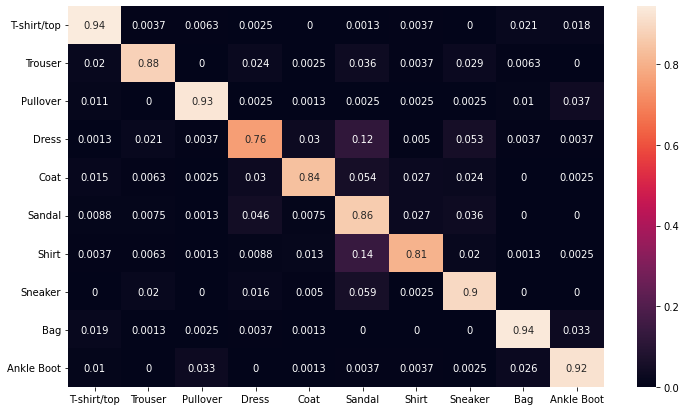

In [10]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = model(inputs.cuda()) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

classes = ('airplane', 'bird', 'car', 'cat', 'deer',
        'dog', 'horse', 'monkey', 'ship', 'truck')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

avg = 'micro'
ic(f'ACCURACY: {accuracy_score(y_true, y_pred)}')
ic(f'RECALL: {recall_score(y_true, y_pred, average=avg)}')
ic(f'PRECISION: {precision_score(y_true, y_pred, average=avg)}')

# FGSM, IFGSM, MIFGSM Attack

In [42]:
def fgsm_attack(input,epsilon,data_grad):

  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):

  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):

  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0

  for i in range(iter-1):
      
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)

    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break

  return pert_out

# Model Evaluation with Adversarial Images

In [80]:
def test(model,device,test_loader,epsilon,attack):

  correct = 0
  adv_examples = []
  model.eval()

  for img, label in test_loader:
      img, label = img.to(device), label.to(device)
      img.requires_grad = True
      output = model(img)

      init_pred = output.max(1, keepdim=True)[1] 

      if init_pred.item != label.item:
          continue

      loss = loss(output, label)
      model.zero_grad()
      loss.backward()
      data_grad = img.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(img,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(img,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(img,epsilon,data_grad)
        
      output_adv = model(perturbed_data)
      final_pred = output_adv.max(1, keepdim=True)[1]
      
      if final_pred.item == label.item:
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item, final_pred.item, adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item, final_pred.item, adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

# Plotting Accuracy curves 

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]

for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []

  for eps in epsilons:
      acc, ex = test(model, 'cuda',train_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)

  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))

  for i in range(len(epsilons)):
      for j in range(len(examples[i])):

          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])

          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")

  plt.tight_layout()
  plt.show()

In [82]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [83]:
%cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [85]:
!jupyter nbconvert --to pdf ML_PROJECT_V_N.ipynb

[NbConvertApp] Converting notebook ML_PROJECT_V_N.ipynb to pdf
[NbConvertApp] Support files will be in ML_PROJECT_V_N_files/
[NbConvertApp] Making directory ./ML_PROJECT_V_N_files
[NbConvertApp] Writing 88646 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 113369 bytes to ML_PROJECT_V_N.pdf
